In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from PIL import Image
from reward import Reward
from helper import detect, capture, pad_inner_array, SocketListener, DataQueue
from pynput import keyboard
from pynput.keyboard import Controller, Key
from concurrent.futures import ThreadPoolExecutor
from collections import deque
from a2c_agent import A2C_Agent
import mss
import time
import pathlib
import os
import json
import random
import logging
import warnings
import sys

In [2]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5
    !pip install -r yolov5/requirements.txt

warnings.simplefilter("ignore", FutureWarning)
logging.getLogger('ultralytics').setLevel(logging.ERROR)

In [ ]:
class AC_Net(nn.Module):
  def __init__(self, input, action_space, lstm_layers=1):
    super(AC_Net, self).__init__()
    self.dropout = nn.Dropout(0.2)
    self.lstm = nn.LSTM(input[1] * input[2], 128, num_layers=lstm_layers, batch_first=True, dropout=0.2, bidirectional=True)
    
    self.actors = nn.ModuleList([
        nn.Sequential(
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, action.n),
        )
        for action in action_space
      ])
    self.critic = nn.Linear(256, 1)
    
  def forward(self, x, hx=None):
    x = x.view(x.size(0), -1, x.size(2) * x.size(3))
    x, hx = self.lstm(x, hx)
    x = x[:, -1, :]
    x = self.dropout(x)
     
    actor_logits = torch.stack([actor(x) for actor in self.actors], dim=1)
    return actor_logits, self.critic(x), hx

In [4]:
class SimOsuEnvironment(gym.Env):
  def __init__(self, stacked_frames=1, max_notes=8, random_select_from_metadata=True, render_mode=True, normalized_rewards=True):
    '''
    args:
      stacked_frames: n frames to stack for observation
      max_notes: n notes with the highest y_center pos to be considered per frame in the observation
      random_select_from_metadata: Randomly select a song from the metadata file for render mode
      render_mode:  The environment will interactive with the game, requires window to be in focus and in song selection screen. 
        Otherwise, simulated mode with pre-recorded frames will be used
      normalized_rewards: Normalizes the rewards based on the number of notes in the song
    '''
    # Common parameters
    self.max_notes = max_notes
    self.stacked_frames = stacked_frames
    self.random_select_from_metadata = random_select_from_metadata
    self.normalized_rewards = normalized_rewards
    self.render_mode = render_mode
    self.keys_reference = ['s', 'd', 'k', 'l'] # Used for keyboard input with index corresponding to a lane
    self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(self.stacked_frames, self.max_notes, 3))
    self.action_space = gym.spaces.MultiDiscrete([4] * len(self.keys_reference))
    self.observation = np.zeros((self.max_notes, 3))
    self.frame_buf = deque(maxlen=self.stacked_frames)
    self.terminated = False
  
    self.invalid_actions = 0 # Counts the number of invalid actions in a step
    self.invalid_action_penalty = -0.1
    self.invalid_action_penalty_scaled = 0 # Scaled invalid action penalty, to be set in reset
    self.total_invalid_actions = 0
    self.actions_taken = np.zeros((4, 4))
    
    self.executor = ThreadPoolExecutor()
    self.reward_func = Reward()
    self.model = None 
    
    self.frame_notes = [] # A note representation of each frame
    
    # Parameters for render mode
    if render_mode:
      self.capture_region = None
      self.keyboard = Controller()
      self.data_queue = DataQueue()
      self.listener = None
      self.listener = SocketListener()
      self.listener.start(data_handler=self.data_queue.add, traceback=False)
      
    self._vision_setup()
    
    # Parameters for simulated mode
    self.custom_reward = [8, 10, 1, -3, -2, -1, -1, -2, -1] # Custom reward function for simulated mode
    self.chosen_folder = None # A randomly chosen folder from available_folders, to be set in reset
    self.available_folders = os.listdir('./frames/rl_simulated_training_sample')
    self.frames = [] # A list of frames in the chosen folder, to be set in reset
    self.metadata = { # Metadata of the chosen song, to be set in reset
      'song_name': "No metadata",
      'song_duration': 0,
      'note_count': 0,
      'hold_note_count': 0,
      'difficulty': 0
    }
    self.frame_step = 0
    self.note_count = 0
    
  def reset(self):
    '''
    Returns to the initial state of the environment and selects a new song
    
    (Warning: Keyboard actions are performed in render_mode on reset, the game should be in focus and in song selection screen)
    '''
    for _ in range(self.stacked_frames):
      self.frame_buf.append(np.zeros((self.max_notes, 3), dtype=np.int32))
    self.observation = np.stack(self.frame_buf, axis=0)
    self.invalid_actions = 0
    self.total_invalid_actions = 0
    self.actions_taken = np.zeros((4, 4))
    self.terminated = False
    
    if self.render_mode:
      if self.listener.has_connection:
        print('Closing connection')
        self.listener.close_connection()
      
      if self.random_select_from_metadata:
        self.metadata = json.load(open('./song_metadata.json'))
        self.metadata = random.choice(self.metadata)
        
      self.data_queue.clear()
      self._get_random_song()
    else:
      random_folder = random.choice(self.available_folders)
      self.chosen_folder = './frames/rl_simulated_training_sample/' + random_folder
      self.frames = sorted(os.listdir(self.chosen_folder))[:-1]
      self.frame_notes = []
      self.frame_step = 0
      
      self.metadata = json.load(open(self.chosen_folder + '/metadata.json'))
      self.reward_func.set_custom_rewards(self.custom_reward)
    
    return self.observation
  
  def step(self, multi_actions):
    if self.render_mode:
      self.observation, reward = self._render_mode_step(multi_actions)
    else:
      self.observation, reward = self._simulated_mode_step(multi_actions)
    
    self.frame_buf.append(self.observation)
    self.observation = np.stack(self.frame_buf, axis=0)
    
    if self.normalized_rewards:
      self.note_count = self.metadata['note_count'] + self.metadata['hold_note_count'] * 2
      reward = ((reward + self.invalid_actions) / self.note_count) * 100
    
    self.total_invalid_actions += self.invalid_actions
    self.invalid_actions = 0
    info = {}
    
    return self.observation, reward, self.terminated, info
    
  def get_meta_data(self):
    '''
    Returns the metadata of the current song in the form of 
    {
      'song_name' (str), \\
      'song_duration' (int) in seconds, \\
      'note_count' (int,) \\
      'hold_note_count' (int), \\
      'difficulty' (float)
    }
    '''
    return self.metadata
  
  def _render_mode_step(self, multi_actions):
    '''
    Steps the environment in render mode, where the game is running and the game window is visible
    '''
    while self.listener.is_first_connection and not self.listener.has_connection:
      pass
    
    img = capture(self.capture_region)
    img = np.array(img)
    
    self._update_observation(img)
    
    actions, action_types = self._parse_multi_actions(multi_actions)
    self.executor.submit(self._perform_keyboard_action, actions, action_types)
    
    data = self.data_queue.get()
    self.data_queue.clear()
    reward = self.reward_func.get_in_game_reward(data) + self.invalid_action_penalty * self.invalid_actions
    
    if not self.terminated:
      self.terminated = (not self.listener.is_first_connection and not self.listener.has_connection) or 6 in data or 7 in data
    
    return self.observation, reward
  
  def _simulated_mode_step(self, multi_actions):
    '''
    Steps the environment in simulated mode, where the pre-recorded frames are used as input
    '''
    img = Image.open(self.chosen_folder + '/' + self.frames[self.frame_step])
    self.frame_step += 1
    
    self._update_observation(img)
    
    actions, _ = self._parse_multi_actions(multi_actions)
    reward = self.reward_func.get_simulated_reward(actions, self.frame_notes[-2] if len(self.frame_notes) > 3 else []) + self.invalid_action_penalty_scaled * self.invalid_actions
    self.terminated = self.frame_step >= len(self.frames)
    
    return self.observation, reward
  
  def _update_observation(self, img):
    vision_thread = self.executor.submit(detect, img, self.model, normalize=True)
    self.observation = vision_thread.result()
    self.frame_notes.append(self.observation)
    self.observation = pad_inner_array([self.observation], [0, 0 ,0], self.max_notes)[0]
    
  def _parse_multi_actions(self, multi_actions):
    '''
    Parses the multi actions into a list of actions and their types
    '''
    parsed_actions = []
    action_type = []
    
    for action_lane, action in enumerate(multi_actions):
      self.actions_taken[action_lane][action] += 1
      
      if action == 0: # Do nothing
        pass
      elif action == 1: # Release
        if not self.reward_func.get_key_held(action_lane):
          self.invalid_actions += 1
          continue
        
        self.reward_func.update_keys_held(action_lane, False)
        parsed_actions.append(action_lane)
      elif action == 2: # Press
        if self.reward_func.get_key_held(action_lane):
          self.invalid_actions += 1
          
        self.reward_func.update_keys_held(action_lane, False)
        parsed_actions.append(action_lane)
      elif action == 3: # Hold
        if not self.reward_func.get_key_held(action_lane):
          parsed_actions.append(action_lane)
        
        self.reward_func.update_keys_held(action_lane, True)

      if action_type != 0:
        action_type.append(action)
          
    return parsed_actions, action_type
  
  def _perform_keyboard_action(self, parsed_actions, action_type):
    for action, action_type in zip(parsed_actions, action_type):
      if action_type in [2, 3]:
        self.keyboard.press(self.keys_reference[action])
        if action_type == 3:
          self.reward_func.update_keys_held(action, True)
      
      if action_type in [1, 2]:
        self.keyboard.release(self.keys_reference[action])
        if action_type == 1:
          self.reward_func.update_keys_held(action, False)
          
  def _get_random_song(self):
    '''
    Choose a random song using in-game menu navigation, game must be in focus and in song selection screen
    '''
    if self.random_select_from_metadata:
      key_sequence = ['a', Key.esc, 'a', Key.esc, *list(self.metadata['song_name']), Key.enter]
    else:
      key_sequence = ['a', Key.esc, Key.f2] + ([Key.down] * np.random.randint(0, 6)) + [Key.enter]
    
    time.sleep(2) 
    for key in key_sequence:
      self.keyboard.press(key)
      time.sleep(0.05)
      self.keyboard.release(key)
    
    time.sleep(3)
    self.executor.submit(self._skip_intro)
  
  def _skip_intro(self):
    for _ in range(10):
      self.keyboard.press(Key.space)
      time.sleep(0.05)
      self.keyboard.release(Key.space)
      time.sleep(0.1)
   
  def _vision_setup(self):
    '''
    Sets up the vision model for object detection, also sets up capture region for render mode
    '''
    if os.name == 'nt':
      pathlib.PosixPath = pathlib.WindowsPath # https://github.com/ultralytics/yolov5/issues/10240#issuecomment-1662573188
    
    if self.render_mode:
      monitor = mss.mss().monitors[-1]
      t, l, w, h = monitor['top'], monitor['left'], monitor['width'], monitor['height']
      self.capture_region = {'left': l+int(w * 0.338), 'top': t, 'width': w-int(w * 0.673), 'height': h} 
      
    self.model = torch.hub.load('ultralytics/yolov5', 'custom', path='./models/best.pt', force_reload=True)
    

In [5]:
osu_env = SimOsuEnvironment(max_notes=4, stacked_frames=12, render_mode=True, normalized_rewards=True)

Listening on 127.0.0.1:5555


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\tiany/.cache\torch\hub\master.zip
YOLOv5  2024-12-4 Python-3.10.6 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [6]:
device = torch.device("cuda")
ac_net = AC_Net(osu_env.observation_space.shape, osu_env.action_space, lstm_layers=4).to(device)
#ac_net.load_state_dict(torch.load('model_results/ac_net_2.pth'))

optimizer = torch.optim.Adam(ac_net.parameters(), lr=0.001)
agent = A2C_Agent(ac_net, osu_env, optimizer, batch_size=128, device=device)

Found [124355, 9546, 28411, 26372] actions
Found hit types Miss: 415, Meh: 165, Ok: 445, Good: 2269, Great: 11866, Perfect: 16947, Passed: 14, Failed: 0


In [7]:
#agent.bc_train(max_episode=20)

In [8]:
#torch.save(ac_net.state_dict(), 'model_results/ac_net_2.pth')

In [9]:
train_total_rewards = agent.train(max_episode=20)

Connection closed.
Actor loss: 527.2698974609375, Value loss: 3.418505907058716, Expert loss: 1.3758652210235596
Episode 0     [Ahoy!! Warera Houshou Kaizokudan] 1.65            Reward:    91.0714, loss:     2.6464
{'miss': 435, 'bad': 178, 'meh': 455, 'ok': 2280, 'great': 11873, 'perfect': 16949, 'song_cleared': 14, 'song_failed': 1}
490
[[        125         125         143         136]
 [        131         130         125         143]
 [        131         127         125         146]
 [        137         114         154         124]]
Connection closed.
Actor loss: 235.5932159423828, Value loss: 0.4592159390449524, Expert loss: 1.3566080331802368
Episode 1     [enchanted love] 2.06                              Reward:    19.8109, loss:     1.1221
{'miss': 23, 'bad': 13, 'meh': 12, 'ok': 11, 'great': 8, 'perfect': 5, 'song_cleared': 0, 'song_failed': 1}
249
[[         90          55          64          66]
 [         66          65          68          76]
 [         77          6

In [ ]:
test_total_rewards = agent.test(max_episode=10)

In [1]:
torch.save(ac_net.state_dict(), 'model_results/ac_net.pth')

NameError: name 'torch' is not defined

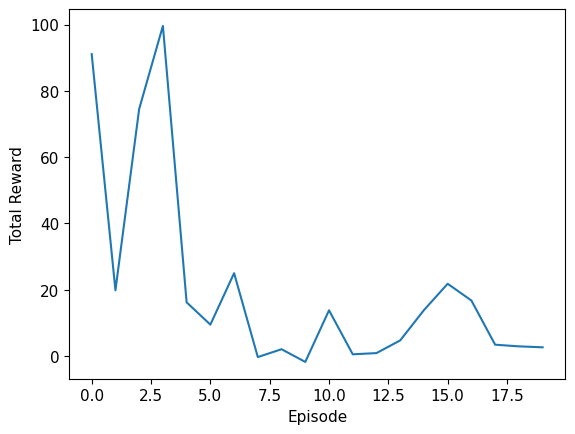

In [11]:
%matplotlib inline
plt.plot(train_total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()